## Stable Diffusion on SPR with IPEX

This is a demo of [Stable Diffusion with the Hugging Face API](https://huggingface.co/stabilityai), and using the [Intel Extension for PyTorch](https://github.com/intel/intel-extension-for-pytorch) (IPEX) to optimize the model pipeline on Intel's 4th generation Xeon platform.

The demo consists of the following steps:

1. Load and define the core SD model components from HF.
2. Set up and run a standard SD pipeline with the HF API, i.e., generate a FP32 precision image.
3. Optimize SD with IPEX, using Auto Mixed Precision (BF16), and run the pipeline again.
4. Compare the results wrt inference latency time.
5. Run batched inference with the optimized SD pipeline.

**This demo is executed in a Conda\* environment.**

The environment is the latest [Intel® oneAPI AI Analytics Toolkit](https://software.intel.com/content/www/us/en/develop/tools/oneapi/ai-analytics-toolkit.html) PyTorch* environment, which includes Intel® Optimizations for deep learning workflows. See [here](https://software.intel.com/content/www/us/en/develop/articles/installing-ai-kit-with-conda.html) for more installation information.

If not yet installed, please make sure to uncomment the following line in order to install Diffusers, Transformers, and update Torch and IPEX.

In [1]:
# ! pip install -U diffusers transformers torch intel_extension_for_pytorch

In [2]:
import torch

from diffusers import AutoencoderKL, DDPMScheduler, PNDMScheduler, StableDiffusionPipeline, UNet2DConditionModel
from diffusers.optimization import get_scheduler
from diffusers.pipelines.stable_diffusion import StableDiffusionSafetyChecker

from transformers import CLIPFeatureExtractor, CLIPTextModel, CLIPTokenizer

import matplotlib.pyplot as plt

import time

Also, we need to register the usage of SD with our personal HF API token. Please paste your token either directly in the cell, or load it from a file. 

In [3]:
# My token
# MY_TOKEN = 'my_hf_api_token'
with open('hf_api.txt') as f:
    MY_TOKEN=f.read()

Please uncomment the following line if verbose oneDNN logging is wanted.

In [4]:
# %env ONEDNN_VERBOSE=1

Next, we load the various pretrained SD model core components from the HF hub:
- The CLIP text tokenizer.
- The CLIP text encoder.
- The UNET.
- And the Autoencoder.

In [5]:
# Load models and create wrapper for stable diffusion
tokenizer = CLIPTokenizer.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="tokenizer", use_auth_token=MY_TOKEN)
text_encoder = CLIPTextModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="text_encoder", use_auth_token=MY_TOKEN)
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet", use_auth_token=MY_TOKEN)
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae", use_auth_token=MY_TOKEN)

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.
Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


Next, we construct the SD pipeline with the HF API. For different performances, experiment, e.g., with the scheduler, and its parameters.

In [6]:
pipeline = StableDiffusionPipeline(
    text_encoder=text_encoder,
    vae=vae,
    unet=unet,
    tokenizer=tokenizer,
    scheduler=PNDMScheduler(beta_start=0.00085, 
                            beta_end=0.012, 
                            beta_schedule="scaled_linear", 
                            skip_prk_steps=True),
    safety_checker=StableDiffusionSafetyChecker.from_pretrained("CompVis/stable-diffusion-safety-checker"),
    feature_extractor=CLIPFeatureExtractor.from_pretrained("openai/clip-vit-base-patch32"))

/home/sdp/anaconda3/envs/sd/lib/python3.9/site-packages/diffusers/pipelines/stable_diffusion/pipeline_stable_diffusion.py:101: FutureWarning: The configuration file of this scheduler: PNDMScheduler {
  "_class_name": "PNDMScheduler",
  "_diffusers_version": "0.11.1",
  "beta_end": 0.012,
  "beta_schedule": "scaled_linear",
  "beta_start": 0.00085,
  "num_train_timesteps": 1000,
  "prediction_type": "epsilon",
  "set_alpha_to_one": false,
  "skip_prk_steps": true,
  "steps_offset": 0,
  "trained_betas": null
}
 is outdated. `steps_offset` should be set to 1 instead of 0. Please make sure to update the config accordingly as leaving `steps_offset` might led to incorrect results in future versions. If you have downloaded this checkpoint from the Hugging Face Hub, it would be very nice if you could open a Pull request for the `scheduler/scheduler_config.json` file
  deprecate("steps_offset!=1", "1.0.0", deprecation_message, standard_warn=False)


**Single image inference**

Then, we call the pipeline with a written description of the wanted image, i.e., the text prompt. And generate an image.

The inference process can be made deterministic by setting the generator seed. Furthermore, through the number of inference steps, we can govern the quality of the image, i.e., more steps equals better quality. Reduce the number of steps to receive results faster.

Please experiment with your own prompts!

In [7]:
prompt = "Painting of a frog with hat on a bicycle cycling in New York City at a beautiful dusk with a traffic jam and moody people in the style of Picasso"

# Setting seed for deterministic output
generator = torch.Generator("cpu").manual_seed(7777)

# Simple timing of inference
start = time.time()
image = pipeline(prompt, num_inference_steps=50, generator=generator).images[0]
end = time.time()
sd_fp32_t = end-start
print(f"Generating one FP32 image took {round(sd_fp32_t, 2)}s")

image.save("frog_test_FP32.png")

  0%|          | 0/50 [00:00<?, ?it/s]

Generating one FP32 image took 118.48s


**Optimization with IPEX**

The UNET component of the model architecture is the one that uses most computational resources in the inference process. Hence, with IPEX, we optimize it, and put it in BF16 precision.
Please note: Experiment also with the optimization of the text encoder.

In [8]:
import intel_extension_for_pytorch as ipex

# Put model in eval mode.
unet.eval()
# text_encoder.eval()

# Optimize the model w/ IPEX
unet = ipex.optimize(unet, dtype=torch.bfloat16)
# text_encoder = ipex.optimize(text_encoder, dtype=torch.bfloat16)

/home/sdp/anaconda3/envs/sd/lib/python3.9/site-packages/intel_extension_for_pytorch/frontend.py:396: UserWarning: Conv BatchNorm folding failed during the optimize process.
  warnings.warn("Conv BatchNorm folding failed during the optimize process.")
/home/sdp/anaconda3/envs/sd/lib/python3.9/site-packages/intel_extension_for_pytorch/frontend.py:401: UserWarning: Linear BatchNorm folding failed during the optimize process.
  warnings.warn("Linear BatchNorm folding failed during the optimize process.")


In [9]:
pipeline = StableDiffusionPipeline(
    text_encoder=text_encoder,
    vae=vae,
    unet=unet,
    tokenizer=tokenizer,
    scheduler=PNDMScheduler(beta_start=0.00085, 
                            beta_end=0.012, 
                            beta_schedule="scaled_linear", 
                            skip_prk_steps=True),
    safety_checker=StableDiffusionSafetyChecker.from_pretrained("CompVis/stable-diffusion-safety-checker"),
    feature_extractor=CLIPFeatureExtractor.from_pretrained("openai/clip-vit-base-patch32"))

In [10]:
prompt = "Painting of a frog with hat on a bicycle cycling in New York City at a beautiful dusk with a traffic jam and moody people in the style of Picasso"

# Setting seed for deterministic output
generator = torch.Generator("cpu").manual_seed(7777)

# Simple timing of inference
start = time.time()
with torch.cpu.amp.autocast():
    image = pipeline(prompt, num_inference_steps=50, generator=generator).images[0]
end = time.time()
sd_bf16_t = end-start
print(f"Generating one BF16 image took {round(sd_bf16_t, 2)}s")

image.save("frog_test_BF16.png")

  0%|          | 0/50 [00:00<?, ?it/s]

[W LegacyTypeDispatch.h:74] Warning: AutoNonVariableTypeMode is deprecated and will be removed in 1.10 release. For kernel implementations please use AutoDispatchBelowADInplaceOrView instead, If you are looking for a user facing API to enable running your inference-only workload, please use c10::InferenceMode. Using AutoDispatchBelowADInplaceOrView in user code is under risk of producing silent wrong result in some edge cases. See Note [AutoDispatchBelowAutograd] for more details. (function operator())


Generating one BF16 image took 38.61s


We compare the inference speeds between the two runs.

In [11]:
print(f"Inference with IPEX, using AMP+BF16, was {round(sd_fp32_t/sd_bf16_t, 2)}x faster.")

Inference with IPEX, using AMP+BF16, was 3.07x faster.


In [12]:
def plotter(outputdict):
    fig = plt.figure(figsize = (10, 5)) 
    plt.bar(outputdict.keys(),outputdict.values(),color=['black', '#0071c5'],width=0.4)
    plt.xlabel("Model")
    plt.ylabel("Eval inference (seconds); lower is better")
    plt.show()

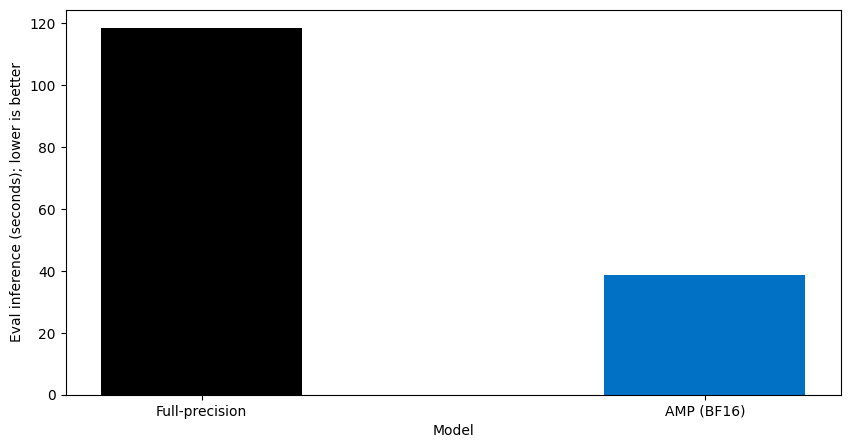

In [13]:
outputDict={"Full-precision":sd_fp32_t,"AMP (BF16)":sd_bf16_t}
plotter(outputDict)

**Batched inference**

Finally, we generate a batch of 3 images, and compare the performance.

In [14]:
from PIL import Image

def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

In [15]:
num_images = 3

prompt = ["Painting of a frog with hat on a bicycle cycling in New York City at a beautiful dusk with a traffic jam and moody people in the style of Picasso"] * num_images

start = time.time()
with torch.cpu.amp.autocast():
    images = pipeline(prompt, num_inference_steps=50).images
end = time.time()
sd_bbf16_t = end-start
print(f"Generating {num_images} BF16 images took {round(sd_bbf16_t, 2)}s. Per image inference time: {round(sd_bbf16_t/num_images, 2)}s.")

grid = image_grid(images, rows=1, cols=3)

grid.save(f"frog_batch.png")

  0%|          | 0/50 [00:00<?, ?it/s]

Generating 3 BF16 images took 129.0s. Per image inference time: 43.0s.
